In [3]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import UpSampling2D
from PIL import Image
from tensorflow.keras.layers import BatchNormalization
import random

In [4]:
# GLOBAL VARIABLES 
os.chdir("/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles")
print("Working Directory:", os.getcwd())
# directories containing desired output, i.e. our y-labels, the ground truth 

base_path = "ObjectDetectedDataset/"
inputTrainPath = base_path + "train/edge_detected"
inputTestPath = base_path + "test/edge_detected" 

outputTrainPath = base_path + "train/tom_jerry_images"
outputTestPath = base_path + "test/tom_jerry_images"

trainingDirectories = [inputTrainPath, outputTrainPath]
testingDirectories = [inputTestPath, outputTestPath]

Working Directory: /Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles


In [5]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(inputDirectories, outputDirectories): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

# takes in two paths of paired images, 
# optionally, one can specify the desired resolution of the image
# whether to display the retrieved images, and whether to convert the images to RGB
# will return the two images as numpy arrays, normalized by dividing by 255
""" Returns two images as two numpy arrays, normalized by dividing by 255

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two rescaled numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")
    else: 
        input_image = input_image.convert("RGB")
        output_image = output_image.convert("RGB")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [6]:
trainingPaths = getFilePaths([trainingDirectories[0]], [trainingDirectories[1]])
testingPaths = getFilePaths([testingDirectories[0]], [testingDirectories[1]])

maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [7]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
# random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []


# THIS VARIABLE AFFECTS THE DIMENSIONS OF ALL IMAGES IN THE DATASET
# IT WILL ALSO AFFECT THE SHAPE OF THE AUTO_ENCODER
personal_image_shape = (128, 128)
for train_input_path, train_output_path in trainingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_train.append(inputImage)
    y_train.append(outputImage)

for train_input_path, train_output_path in testingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_test.append(inputImage)
    y_test.append(outputImage)


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [8]:
# Confirming sizes of datsets and shapes of the datasets
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

983 983
368 368
(983, 128, 128)
(983, 128, 128)
(368, 128, 128)
(368, 128, 128)


In [9]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = tf.keras.Sequential([
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        ])
        self.middle = Conv2D(512, (3, 3), activation='relu', padding='same')
        self.decoder = tf.keras.Sequential([
            UpSampling2D((2,2)), 
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2,2)), 
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2,2)), 
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
        ])
        self.output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')

    def call(self, x):
        x = tf.expand_dims(x, axis=-1)
        encoded = self.encoder(x)
        middle = self.middle(encoded)
        decoded = self.decoder(middle)
        output = self.output_layer(decoded)
        return output

unet_model = UNet()
callback = EarlyStopping(monitor="val_loss", patience=15)
unet_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
history_unet = unet_model.fit(train_dataset, epochs=10, shuffle=True, validation_data=test_dataset, callbacks=callback)



Epoch 1/10
16/16 [==============================] - 276s 17s/step - loss: 0.1011 - val_loss: 0.4646
Epoch 2/10
16/16 [==============================] - 287s 18s/step - loss: 0.0584 - val_loss: 0.0965
Epoch 3/10
16/16 [==============================] - 314s 20s/step - loss: 0.0480 - val_loss: 0.0676
Epoch 4/10
16/16 [==============================] - 321s 20s/step - loss: 0.0420 - val_loss: 0.1017
Epoch 5/10
16/16 [==============================] - 317s 20s/step - loss: 0.0387 - val_loss: 0.1218
Epoch 6/10
16/16 [==============================] - 317s 20s/step - loss: 0.0367 - val_loss: 0.1542
Epoch 7/10
16/16 [==============================] - 361s 23s/step - loss: 0.0354 - val_loss: 0.1647
Epoch 8/10
16/16 [==============================] - 356s 22s/step - loss: 0.0342 - val_loss: 0.1696
Epoch 9/10
16/16 [==============================] - 359s 22s/step - loss: 0.0328 - val_loss: 0.1472
Epoch 10/10
16/16 [==============================] - 323s 20s/step - loss: 0.0316 - val_loss: 0.1118

In [14]:
unet_model.summary()


Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 16, 16, 256)       1147840   
                                                                 
 conv2d_6 (Conv2D)           multiple                  1180160   
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 64)      2326912   
                                                                 
 conv2d_13 (Conv2D)          multiple                  65        
                                                                 
Total params: 4654977 (17.76 MB)
Trainable params: 4651393 (17.74 MB)
Non-trainable params: 3584 (14.00 KB)
_________________________________________________________________


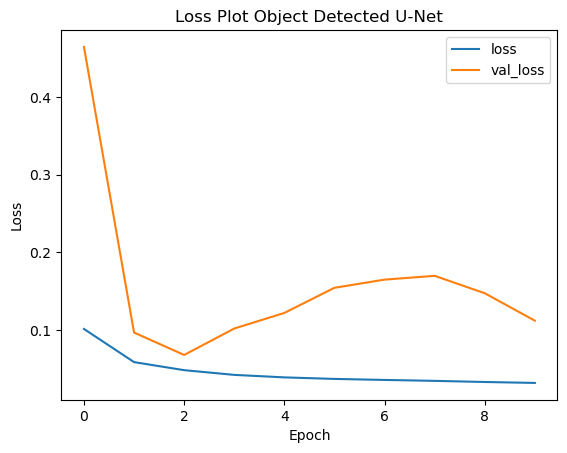

In [19]:
# print training and value loss
plt.plot(history_unet.history['loss'], label='loss')
plt.plot(history_unet.history['val_loss'], label='val_loss')
plt.title("Loss Plot Object Detected U-Net")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

12/12 [==============================] - 30s 3s/step


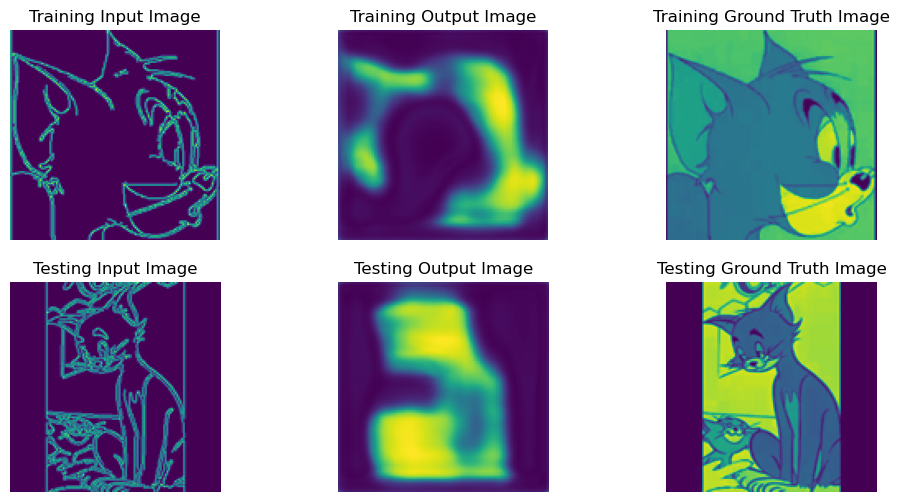

In [12]:
# Display images for testing

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = unet_model.predict(x_train)[trainImageIndex]
test_output_image = unet_model.predict(x_test)[testImageIndex]

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

In [15]:
unet_model.save("src/SavedModels/ObjectDetectedU-Net.keras")